# SPMpy 
* Authors : Dr. Jewook Park at CNMS, ORNL
    * Center for Nanophase Materials Sciences (CNMS), Oak Ridge National Laboratory (ORNL)
    * email :  parkj1@ornl.gov
        
> **SPMpy** is a python package to analysis scanning probe microscopy (SPM) data analysis, such as scanning tunneling microscopy and spectroscopy (STM/S) data and atomic force microscopy (AFM) images, which are inherently multidimensional. SPMpy exploits recent image processing(a.k.a. Computer Vision) techniques, and utilzes [building blocks](https://scipy-lectures.org/intro/intro.html#the-scientific-python-ecosystem) and excellent visualization tools available in the [scientific python ecosystem](https://holoviz.org/index.html). Many parts are inspired by well-known SPM data analysis programs, for example, [Wsxm](http://www.wsxm.eu/) and [Gwyddion](http://gwyddion.net/). SPMpy is trying to apply lessons from [Fundamentals in Data Visualization](https://clauswilke.com/dataviz/).

>  **SPMpy** is an open-source project. (Github: https://github.com/jewook-park/SPMpy_ORNL )
> * Contributions, comments, ideas, and error reports are always welcome. Please use the Github page or email parkj1@ornl.gov. Comments & remarks should be in Korean or English. 

# Create pptx file to summarize 2D SPM dataset 


* use *fileloading_functions* in SPMpy_ORNL
    * **Nanonis** 2D data (*.sxm) files  $\to$  **Xarray** (DataSet or DataArray) (or **PANDAS**  (DataFrame) )
* create pptx file $\to$ add image title & 2D images
    * add image title ( scan condition info & experimental conditions ) 
    * topography + LDOS image(locking dI/dV)
    * generate FFT 
    * save pptx
    


# <font color= orange > 0. Preparation  </font>

In [1]:
#############################
# check all necessary package
#############################

import glob
import os
from warnings import warn

import numpy as np
import pandas as pd

try:
    from ipyfilechooser import FileChooser
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named ipyfilechooser")
    %from ipyfilechooser import FileChooser

try:
    import xrft
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named xrft")
    !pip install xrft
    import xrft

In [2]:
########################################
#    * Step 1-1
#    : Import necessary packages
#        import modules
#########################################

import glob
import math
import os
from warnings import warn

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import skimage
from scipy import signal
from SPMpy_2D_data_analysis_funcs import *
from SPMpy_fileloading_functions import (
    grid2xr,
    grid_line2xr,
    gwy_df_ch2xr,
    gwy_img2df,
    img2xr,
)

# some packages may be yet to be installed
try:
    from pptx import Presentation
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named Presentation")
    !pip install python-pptx
    from pptx import Presentation
    from pptx.util import Inches, Pt

try:
    import nanonispy as nap
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named nanonispy")
    !pip install nanonispy
    import nanonispy as nap

try:
    import seaborn_image as isns
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named seaborn-image")
    #!pip install --upgrade scikit-image == 0.19.0.dev0
    !pip install --upgrade seaborn-image
    import seaborn_image as isns

try:
    import xarray as xr
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named xarray")
    #!pip install --upgrade scikit-image == 0.19.0.dev0
    !pip install xarray
    import xarray as xr

try:
    import xrft
except ModuleNotFoundError:
    warn("ModuleNotFoundError: No module named xrft")
    !pip install xrft
    import xrft

# <font color= orange > 1. Choose Folder & DataFrame for files  </font>

In [3]:
###########################################
# Create and display a FileChooser widget #
###########################################
file_chooser = FileChooser("")
display(file_chooser)

FileChooser(path='C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\Research\Data Analysis (python)\SPMpy_…

In [19]:
##############################
# After choose the folder    #
# Files DataFrame            #
##############################

folder_path = file_chooser.selected_path
print("folder_path = ", file_chooser.selected_path)
print("selected file name = ", file_chooser.selected_filename)
from SPMpy_fileloading_functions import files_in_folder

files_df = files_in_folder(folder_path)

folder_path =  C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\mK STM DATA\2023\0510FeTe0.55Se0.45_new_batch1_PtIrTip3_mK_B_field_Jewook
selected file name =  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_2T_10001.sxm
Current Path =  C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\mK STM DATA\2023\0507 FeTe0.55Se0.45_new_batch1_PtIrTip3_mK_start_Jewook
Changed Path =  C:\Users\gkp\OneDrive - Oak Ridge National Laboratory\mK STM DATA\2023\0510FeTe0.55Se0.45_new_batch1_PtIrTip3_mK_B_field_Jewook
                                                group  num  \
0   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  001   
1   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  002   
2   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  003   
3   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  001   
4   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  002   
5   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  003   
6   FeTe0.55Se0.45(new)_PtIrTip3_mK_

# <font color= orange > 2. loading files & data import    </font>

In [20]:
#######

files_df

sxm_file_list_df = files_df[files_df.type == "sxm"]
# file_list_df
sxm_file_groups = list(set(files_df["group"]))
# file groups

#############################
# sxm file loading by using img2xr
# xr format으로 파일 불러오기
# (e.g.) # img2xr(file_list_df.file_name.iloc[0])
#############################
# spmdata_xr = img2xr(file_list_df.file_name[0])

# <font color= orange > 3. Creating PPTX file </font>

In [21]:
###############################
# new pptx file 
# overwrite everytime 
###############################

folder_name  = os.getcwd().split('\\')[-1]
# final folder 
pptx_file_name =  folder_name+ '_automated.pptx'

prs = Presentation() # empty_file #빈파일 하나 지정 
#``` Page 0 ``````````
sld0_slide_layout = prs.slide_layouts[0] # title slide (layout_type =  [0] )

slide0 = prs.slides.add_slide(sld0_slide_layout)
# add title slide in the pptx file # 슬라이드를 하나 더했음. 

# title page set up 
sld0_title = slide0.shapes.title
sld0_subtitle = slide0.placeholders[1]
# title & sub_title for the title slide  
# 0 번째 슬라이드에 title과 subtitle 넣음 
sld0_title.text = 'Nanonois 2D images' + '\n' +  'in '+ folder_name 
# title 지정 
sld0_subtitle.text = 'by using SPMpy \n  Jewook Park '

#``` Page 1 ``````````

sld1_slide_layout = prs.slide_layouts[1] # bullet_slide # title+content
slide1 = prs.slides.add_slide(sld1_slide_layout)
#add page  1 slide
slide1_title  = slide1.shapes.title
slide1_contents  = slide1.shapes.placeholders[1].text_frame
# choose 'shapes' in 'slide1' 
# assigne 'title' & 'contents(text)'  in 'shapes' 

slide1_title.text = 'file list (*.sxm)' # 제목설정 
slide1_contents.text = 'file groups' # 내용설정
# add 'text' in the 'title'  object 

for group in sxm_file_groups:
    sld1_paragraph_1 = slide1_contents.add_paragraph()
    sld1_paragraph_1.text = group
    sld1_paragraph_1.level = 2   
    # add paragraph in the contents  : group name
    sld1_paragraph_1 = slide1_contents.add_paragraph()
    sld1_paragraph_1.text = files_df[files_df.group ==  group].file_name.min() + '\n ~ ' + files_df[files_df.group ==  group].file_name.max()
    sld1_paragraph_1.level = 3    
    # add paragraph in the contents  : Files (start-end) name
    # 내용에 단락 추가
prs.save(pptx_file_name)  

# add group_name & number of files as a paragraph




# <font color= orange > 4. add data page </font>

In [22]:
files_df

group  num  \
0   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  001   
1   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  002   
2   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  003   
3   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  001   
4   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  002   
5   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  003   
6   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  004   
7   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  001   
8   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  002   
9   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  003   
10  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  003   
11  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  004   
12  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  001   
13  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  002   
14         Grid Spectroscopy X0.01F0.01_after1T_10004  002   
15         Grid Spectroscopy X0.01F0.01_after2T_10002  001   
16         Grid Spectroscopy X0.01F0.01_after2T_10002  002   
17         Grid Spectroscopy X0.01F0.01_after3T_10002  001   
18         Grid Spectroscopy X0.01F0.01_after3T_10004  001   
19  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   
20  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   
21  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   
22  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   
23  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   
24  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   
25  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  NaN   

                                            file_name type  
0   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
1   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
2   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
3   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
4   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
5   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
6   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  sxm  
7   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
8   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
9   FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
10  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
11  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
12  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
13  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0....  sxm  
14  Grid Spectroscopy X0.01F0.01_after1T_10004002.3ds  3ds  
15  Grid Spectroscopy X0.01F0.01_after2T_10002001.3ds  3ds  
16  Grid Spectroscopy X0.01F0.01_after2T_10002002.3ds  3ds  
17  Grid Spectroscopy X0.01F0.01_after3T_10002001.3ds  3ds  
18  Grid Spectroscopy X0.01F0.01_after3T_10004001.3ds  3ds  
19  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy  
20  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy  
21  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy  
22  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy  
23  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy  
24  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy  
25  FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0....  gwy

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_2T_10001
400 nm x 200 nm  V = 0.02 V  I = 100 pA 
['LI_Demod_1_X']
size_x != size_y
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


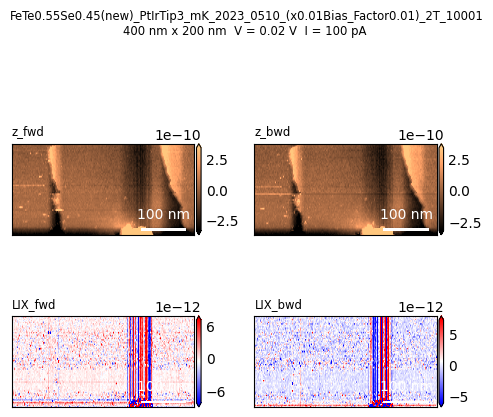

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


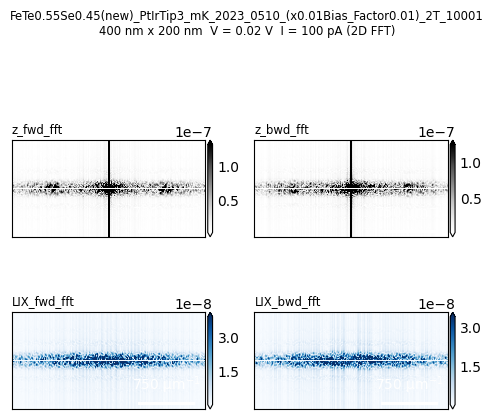

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_2T_10002
320 nm x 320 nm  V = 0.01 V  I = 100 pA 
['LI_Demod_1_X']
step_dx/step_dy =  4.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


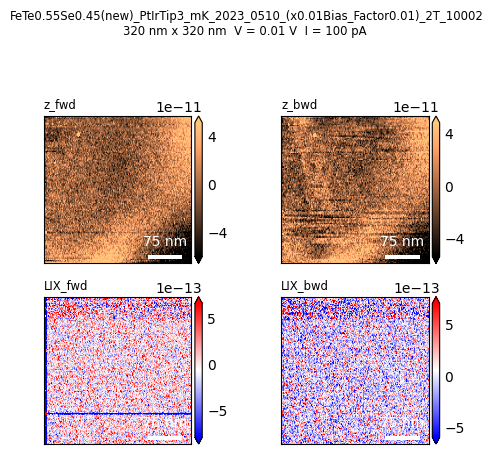

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


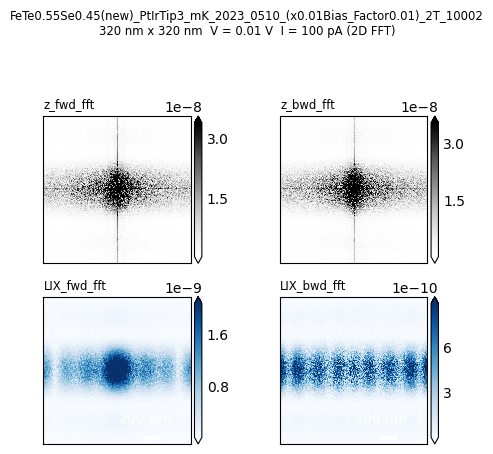

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_2T_10003
200 nm x 200 nm  V = 0.0011 V  I = 100 pA 
['LI_Demod_1_X']
step_dx/step_dy =  4.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


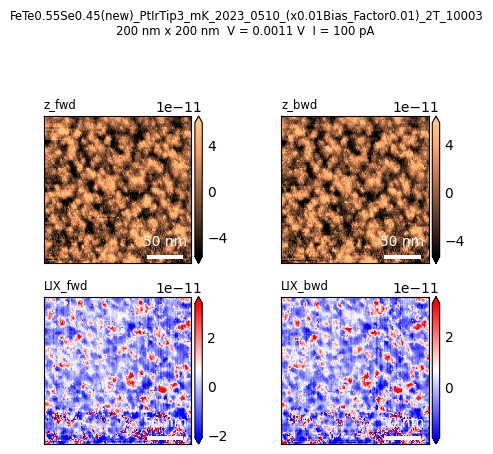

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


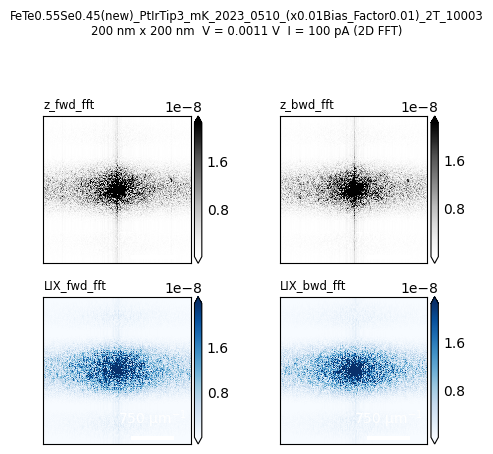

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_3T_10001
200 nm x 200 nm  V = 0.0016 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


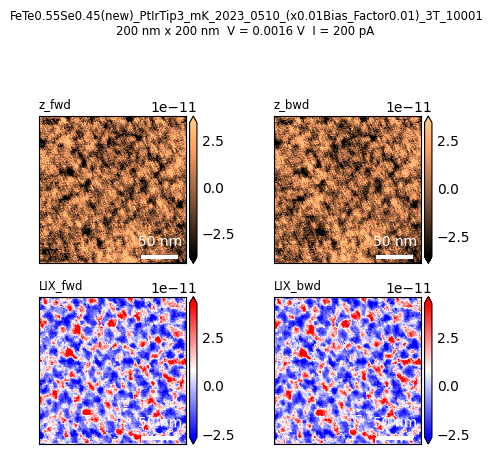

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


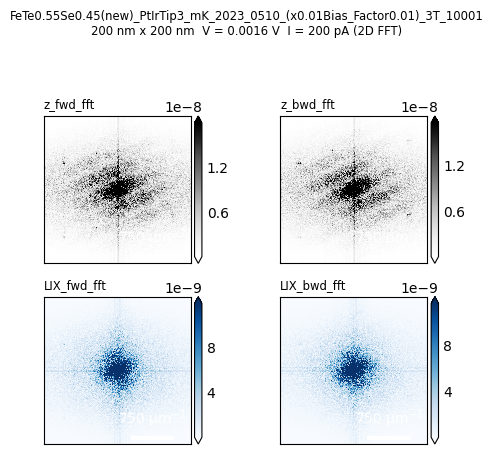

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_3T_10002
160 nm x 160 nm  V = 0.0016 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 512, 'X': 512"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


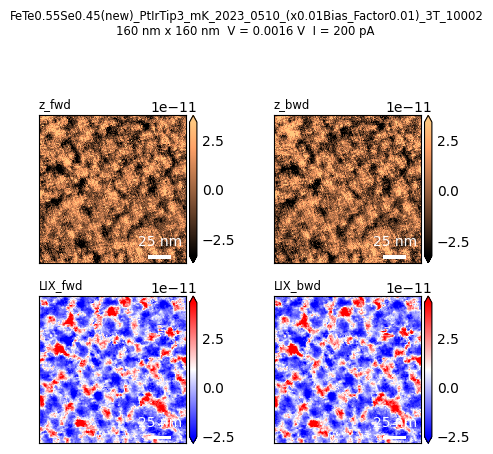

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


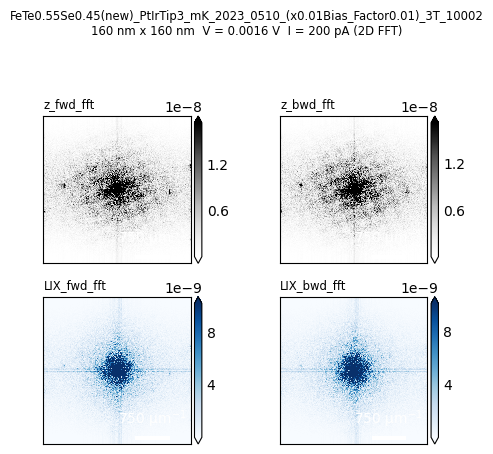

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_3T_10003
80 nm x 80 nm  V = -0.001 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


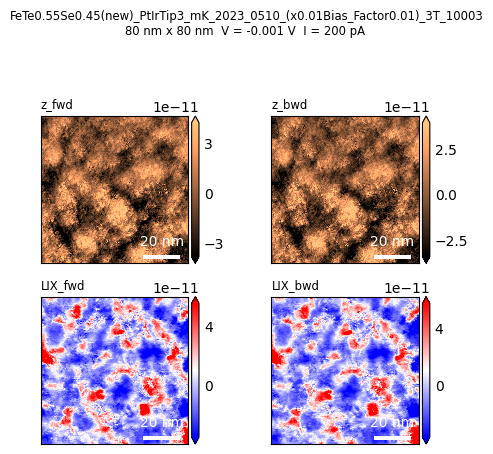

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


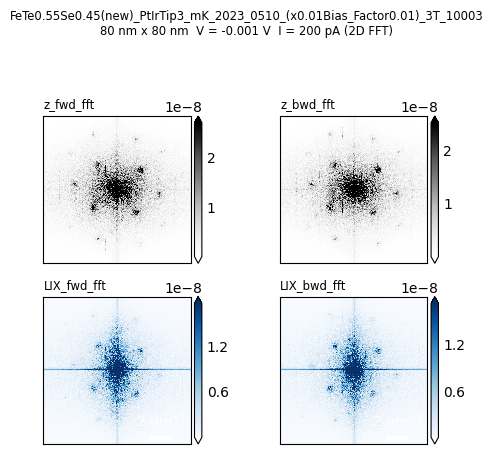

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0510_(x0.01Bias_Factor0.01)_3T_10004
20 nm x 20 nm  V = -0.001 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


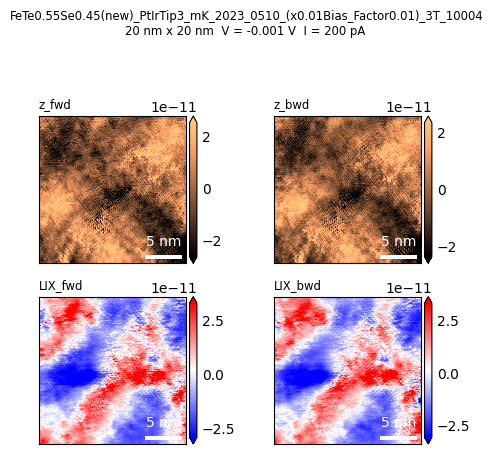

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


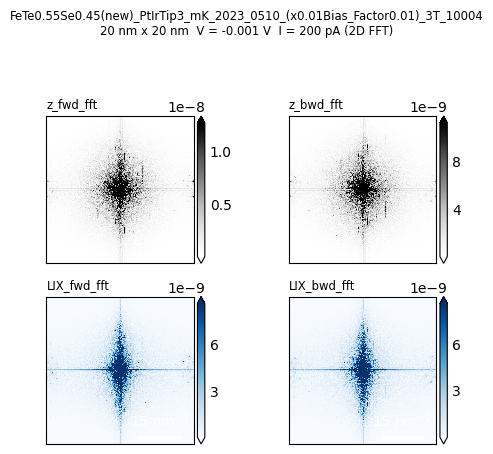

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_0T_10001
200 nm x 200 nm  V = 0.0016 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


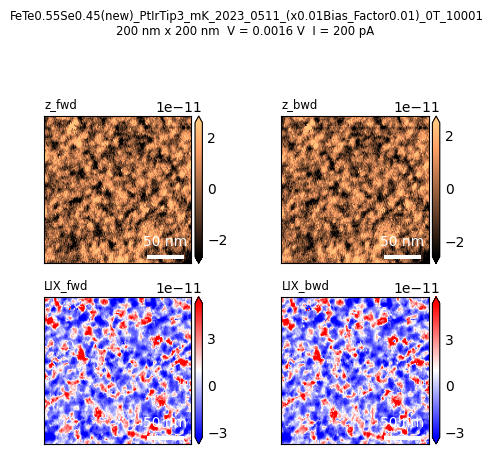

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


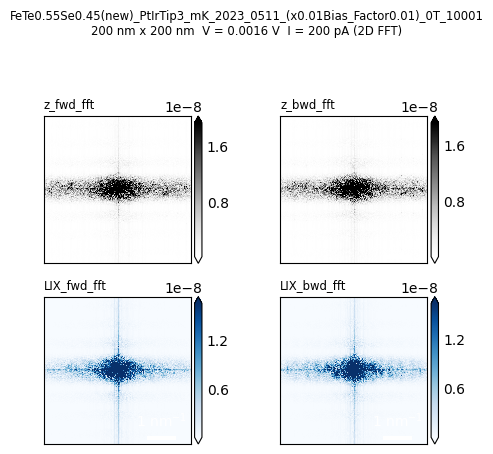

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_0T_10002
400 nm x 400 nm  V = 0.0016 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


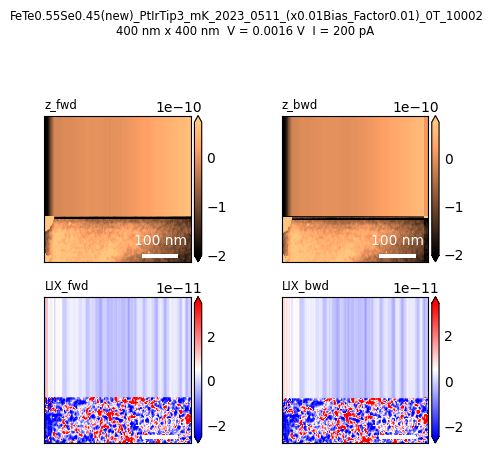

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


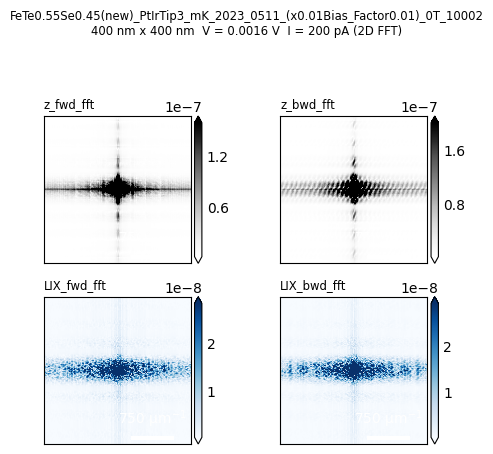

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_0T_10003
320 nm x 320 nm  V = 0.0016 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


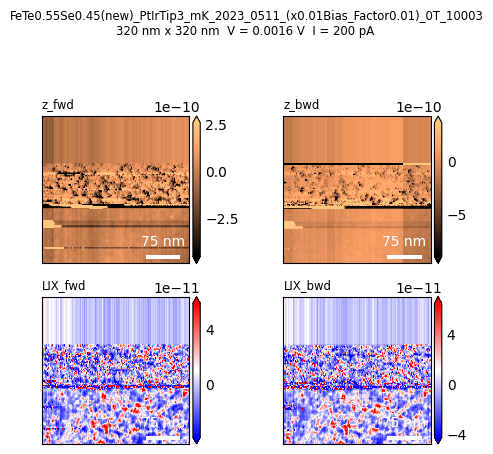

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


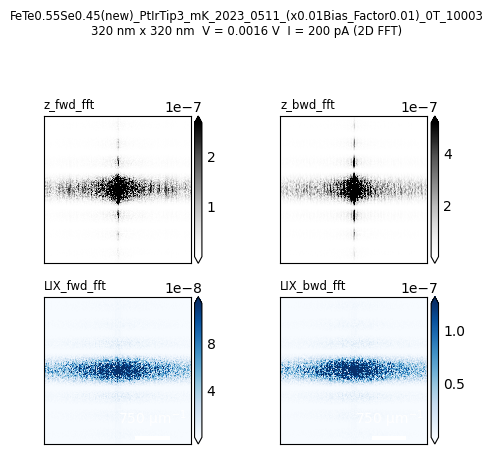

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_1T_10003
200 nm x 200 nm  V = 0.002 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


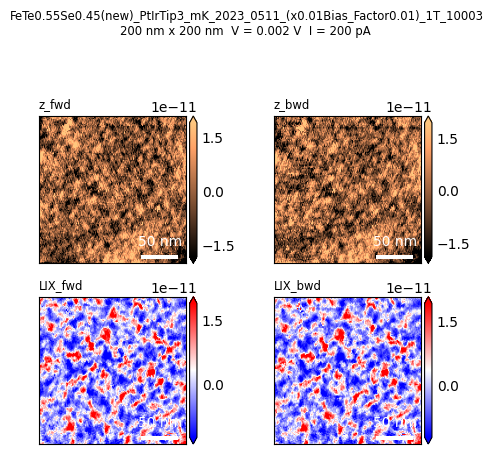

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


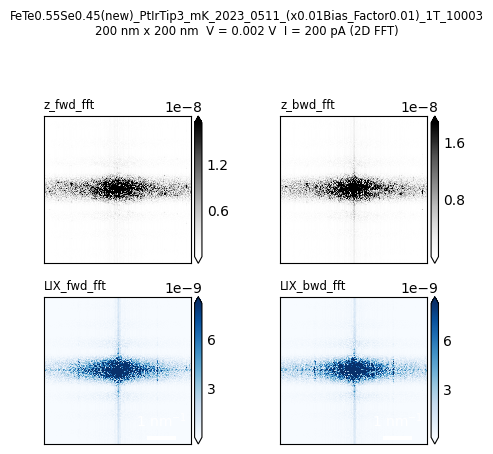

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_1T_10004
200 nm x 200 nm  V = 0.0016 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


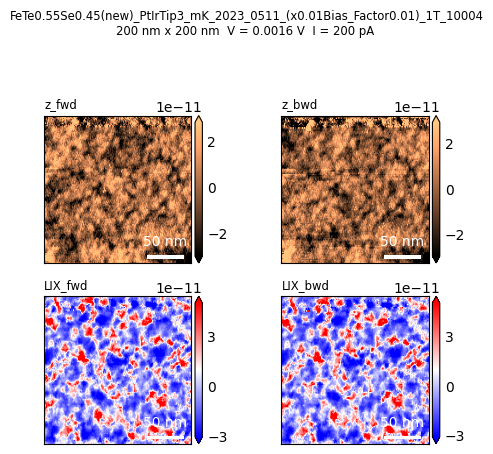

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


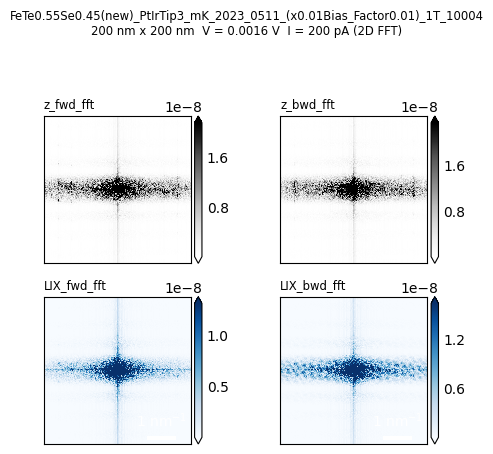

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_3T_10001
20 nm x 20 nm  V = 0.001 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  2.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


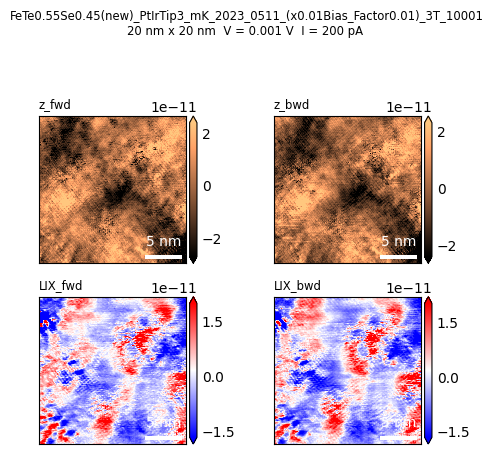

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


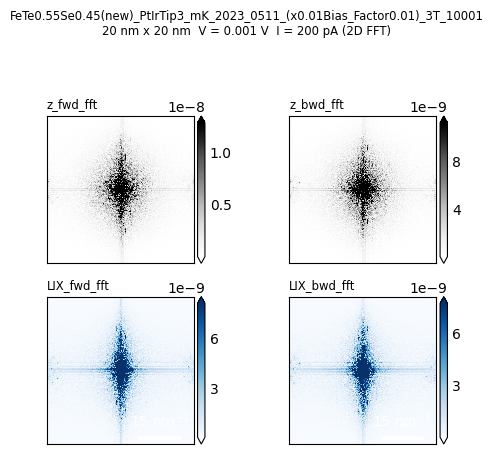

scan direction (up/down):  up
FeTe0.55Se0.45(new)_PtIrTip3_mK_2023_0511_(x0.01Bias_Factor0.01)_3T_10002
200 nm x 200 nm  V = 0.002 V  I = 200 pA 
['LI_Demod_1_X']
step_dx/step_dy =  8.0
z_LIX_fNb_xr ==> reshaped
z_LIX_fNb_xr step_dx, step_dy =  ["'Y': 1024, 'X': 1024"]
tip material will be announced
z_fwd_isns
z_bwd_isns
LIX_fwd_isns
LIX_bwd_isns


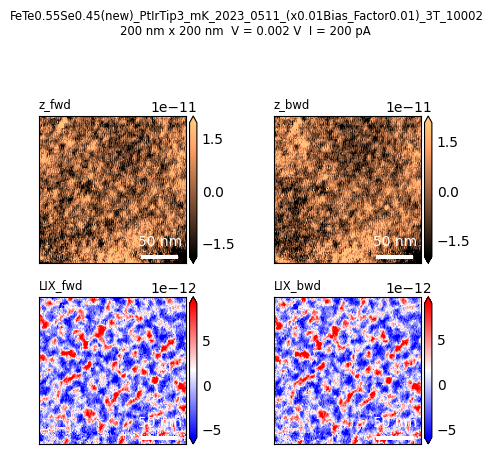

np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
np.log & np.abs after fft
z_fwd_fft_isns
z_bwd_fft_isns
LIX_fwd_fft_isns
LIX_bwd_fft_isns


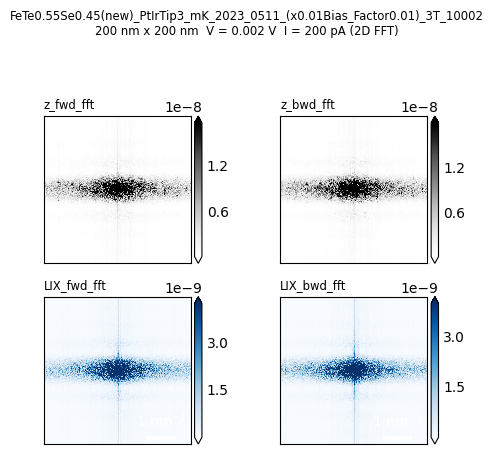

UnhandledFileError: Grid Spectroscopy X0.01F0.01_after1T_10004002.3ds is not a sxm file

In [23]:
#from pptx import Presentation
from pptx.util import Inches
from pptx.util import Cm, Pt

for files_name in files_df.file_name:
    spmdata_xr = img2xr(files_name)

    # open previously prepared pptx 
    prs = Presentation(pptx_file_name)


    img_sld_slide_layout = prs.slide_layouts[6] # image slide (layout_type =  [6] )
    img_sld = prs.slides.add_slide(img_sld_slide_layout)
    # textbox setting
    left_textbox = Inches(0)
    top_textbox = Inches(0)
    width_textbox = Inches(4)
    height_textbox = Inches(1)
    txBox  = img_sld.shapes.add_textbox(left_textbox, top_textbox,width_textbox,height_textbox )
    
    tx_frame = txBox.text_frame 
    tx_frame.text =  spmdata_xr.title
    
    # real space figure 
    left = Inches(0)
    top = Inches(1)

    spm_data_plot = xr_isns_plot_r_space(plane_fit_x_xr(plane_fit_y_xr(spmdata_xr)),
                                         figsize= (5,6))
    spm_data_plot.savefig('spm_data_plot_temp.png', 
                          bbox_inches='tight', dpi = 300)

    r_space_img = img_sld.shapes.add_picture('spm_data_plot_temp.png', 
                                           left, 
                                           top)
    # momentum space figure
    spm_data_fft_plot = xr_isns_plot_k_space(twoD_FFT_xr( plane_fit_x_xr(plane_fit_y_xr(spmdata_xr))), 
                                             figsize= (5,6),
                                             zoom_in_fft= False, zoom_in_expand= False)

    spm_data_fft_plot.savefig('spm_data_fft_plot_temp.png',bbox_inches='tight', dpi = 300)
    left_2 = Inches(5)

    k_space_img = img_sld.shapes.add_picture('spm_data_fft_plot_temp.png',
                                           left_2,
                                           top)
    prs.save(pptx_file_name)  


#pptx page 